In [ ]:
# Here are some statistics from the review tasks

## Inter-reviewer Agreement on spans
From chatgpt: this finds the number of exact matches from all 7 reviewers


In [ ]:
!git clone https://github.com/abecode/teaching_reviews

Cloning into 'teaching_reviews'...
remote: Enumerating objects: 237, done.
remote: Counting objects: 100% (237/237), done.
remote: Compressing objects: 100% (204/204), done.
remote: Total 237 (delta 121), reused 126 (delta 32), pack-reused 0 (from 0)
Receiving objects: 100% (237/237), 4.90 MiB | 847.00 KiB/s, done.
Resolving deltas: 100% (121/121), done.


In [ ]:
!ls -lrt teaching_reviews/data_jsonl

total 95296
-rw-r--r-- 1 root root  5488435 May 12 19:52 teaching_reviews_pilot1_spans_20250401.json
-rw-r--r-- 1 root root 37667169 May 12 19:52 teaching_reviews_pilot1_spans_reviews_20250414.json
-rw-r--r-- 1 root root 54210264 May 12 19:52 teaching_reviews_pilot1_spans_reviews_20250422.json
-rw-r--r-- 1 root root    75336 May 12 19:52 teaching_reviews_whole_review.jsonl
-rw-r--r-- 1 root root   131264 May 12 19:52 teaching_reviews_sentences.jsonl


In [ ]:
import json
from collections import defaultdict, Counter
from pathlib import Path

def load_jsonl(path):
    with open(path, 'r', encoding='utf-8') as f:
        return [json.loads(line) for line in f]

def spans_to_set(spans):
    """Convert spans list to a hashable set of (start, end, label)."""
    return frozenset((s["start"], s["end"], s["label"]) for s in spans)

# Load your review dataset (produced by `prodigy review ...`)
#data = load_jsonl("teaching_reviews/data_jsonl/teaching_reviews_pilot1_spans_reviews_20250414.json")
data = load_jsonl("teaching_reviews/data_jsonl/teaching_reviews_pilot1_spans_reviews_20250422.json")

# Group by input_hash
reviews_by_input = defaultdict(list)
for eg in data:
    if "spans" in eg and "answer" in eg and eg["answer"] == "accept":
        reviews_by_input[eg["_input_hash"]].append(eg)

# Analyze agreement
total_reviewed = 0
total_agreed = 0
disagreements = []

for input_hash, reviews in reviews_by_input.items():
    if len(reviews) < 2:
        continue  # need at least two reviewers

    total_reviewed += 1
    span_sets = [spans_to_set(r["spans"]) for r in reviews]
    first = span_sets[0]
    if all(s == first for s in span_sets[1:]):
        total_agreed += 1
    else:
        disagreements.append({
            "text": reviews[0]["text"],
            "reviewers": [r.get("_reviewer_id", r.get("_session_id", "unknown")) for r in reviews],
            "span_sets": span_sets
        })

# Report
print(f"🧾 Inputs reviewed by 2+ reviewers: {total_reviewed}")
print(f"✅ Perfect agreement on spans:     {total_agreed}")
print(f"❌ Disagreements:                  {total_reviewed - total_agreed}")
print(f"🧮 Agreement rate: {total_agreed / total_reviewed:.2%}" if total_reviewed else "No overlapping reviews")

# Optional: print first few disagreements
for i, d in enumerate(disagreements[:3]):
    print(f"\nDisagreement #{i+1}")
    print(f"Text: {d['text']}")
    for reviewer, spans in zip(d["reviewers"], d["span_sets"]):
        print(f"- {reviewer}: {spans}")

🧾 Inputs reviewed by 2+ reviewers: 192
✅ Perfect agreement on spans:     15
❌ Disagreements:                  177
🧮 Agreement rate: 7.81%

Disagreement #1
Text: Abe is a practical, passionate, and thoughtful teacher who knows how to balance between making sure that students are learning the material and getting fair grades. My only feedback is that the class seems to be covering a lot of materials, 3 hours and 15 mins don't seem enough to cover it all, at some point by the end of each class most students check out and it became just a matter of being there, maybe a better distribution of class activity will be helpful, more peer interaction and cut back on some of the material or demand that student read three pages which covers the basics of each day's class before they come to the class.
- pilot1_review-Henry%20%20(replace%20%3Cyour%20name%3E%20with%20your%20first%20name: frozenset({(165, 295, 'NEGATIVE'), (0, 163, 'REDACT'), (403, 639, 'SUGGESTION'), (296, 402, 'NEGATIVE'), (0, 164,

## Confusion Matrix of Reviewer Disagreements by Label
Also from ChatGPT.  This calculates the number of times reviewers agree on labels (diagonal) or disagree (off-diagonal cells)

In [ ]:
import pandas as pd

In [ ]:

def span_overlap(span1, span2):
    """Check if two spans (start, end) overlap."""
    return span1[0] < span2[1] and span2[0] < span1[1]

def extract_spans(span_list):
    """Convert spans to (start, end, label) format."""
    return [(s["start"], s["end"], s["label"]) for s in span_list]

# Load review dataset
#data = load_jsonl("spancat_review_dataset.jsonl")

# Group by _input_hash
reviews_by_input = defaultdict(list)
for eg in data:
    if "spans" in eg and "answer" in eg and eg["answer"] == "accept":
        reviewer = eg.get("_reviewer_id") or eg.get("_session_id") or "unknown"
        reviews_by_input[eg["_input_hash"]].append({
            "text": eg["text"],
            "reviewer": reviewer,
            "spans": extract_spans(eg["spans"])
        })

# Confusion matrix counter
confusion = Counter()

# Compare span labels for reviewer pairs
for input_hash, reviews in reviews_by_input.items():
    if len(reviews) < 2:
        continue

    for i in range(len(reviews)):
        for j in range(i+1, len(reviews)):
            ri, rj = reviews[i], reviews[j]
            spans_i = ri["spans"]
            spans_j = rj["spans"]
            for si in spans_i:
                for sj in spans_j:
                    if span_overlap((si[0], si[1]), (sj[0], sj[1])):
                        key = (si[2], sj[2])  # (label_i, label_j)
                        confusion[key] += 1

# Convert to confusion matrix (pandas DataFrame)
labels = sorted(set(l for pair in confusion.keys() for l in pair))
matrix = pd.DataFrame(index=labels, columns=labels).fillna(0)

for (label_i, label_j), count in confusion.items():
    matrix.at[label_i, label_j] = count

print("📊 Reviewer Label Confusion Matrix (overlapping spans):")
display(matrix.style.background_gradient(cmap="Blues"))

📊 Reviewer Label Confusion Matrix (overlapping spans):


<ipython-input-6-978b8f93c0aa>:44: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  matrix = pd.DataFrame(index=labels, columns=labels).fillna(0)


,COMPARISON,NEGATIVE,POSITIVE,REDACT,SUGGESTION,UNSURE
COMPARISON,91,17,13,44,0,1
NEGATIVE,16,3713,106,1087,101,86
POSITIVE,31,115,7368,3890,110,80
REDACT,43,996,3718,4405,440,142
SUGGESTION,11,130,80,452,3054,20
UNSURE,19,53,36,128,18,131


## confusion matrix between reviewers
This counts the number of times each reviewer agrees or disagrees

I think there might be a problem with it.  I think if an annotator doesn't give a label, we should try to consider that a neutral label. Otherwise, I think the counts may be incorrect.

In [ ]:
# compute agreement between annotator pairs
# Confusion matrix counter
annotator_confusion = Counter()

for input_hash, reviews in reviews_by_input.items():
    if len(reviews) < 2:
        continue
    #print(input_hash, reviews)

    for i in range(len(reviews)):
        for j in range(len(reviews)):
            ri, rj = reviews[i], reviews[j]
            annotator_i = ri["reviewer"]
            annotator_j = rj["reviewer"]
            spans_i = ri["spans"]
            spans_j = rj["spans"]
            for si in spans_i:
                for sj in spans_j:
                    if span_overlap((si[0], si[1]), (sj[0], sj[1])):
                        key = (annotator_i, annotator_j)
                        annotator_confusion[key] += 1


# Convert to confusion matrix (pandas DataFrame)
annotators = sorted(set(l for pair in annotator_confusion.keys() for l in pair))
#print(annotators)
matrix = pd.DataFrame(index=annotators, columns=annotators).fillna(0)

for (label_i, label_j), count in annotator_confusion.items():
    matrix.at[label_i, label_j] = count

print("📊 Reviewer Label Confusion Matrix (overlapping spans):")
display(matrix.style.background_gradient(cmap="Blues"))

📊 Reviewer Label Confusion Matrix (overlapping spans):


<ipython-input-7-06d2a8e49441>:27: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  matrix = pd.DataFrame(index=annotators, columns=annotators).fillna(0)


,pilot1_review-Henry%20%20(replace%20%3Cyour%20name%3E%20with%20your%20first%20name,pilot1_review-Jenny,pilot1_review-abe,pilot1_review-manojkumar,pilot1_review-meenu,pilot1_review-mengyuan,pilot1_review-rohith
pilot1_review-Henry%20%20(replace%20%3Cyour%20name%3E%20with%20your%20first%20name,1610,1380,1591,1588,1449,1438,1526
pilot1_review-Jenny,1380,1335,1418,1461,1279,1243,1352
pilot1_review-abe,1591,1418,1681,1598,1493,1431,1567
pilot1_review-manojkumar,1588,1461,1598,2106,1456,1460,1537
pilot1_review-meenu,1449,1279,1493,1456,1419,1337,1441
pilot1_review-mengyuan,1438,1243,1431,1460,1337,1356,1395
pilot1_review-rohith,1526,1352,1567,1537,1441,1395,1522


In [ ]:
reviews_by_input[list(reviews_by_input.keys())[0]]

[{'text': "Abe is a practical, passionate, and thoughtful teacher who knows how to balance between making sure that students are learning the material and getting fair grades. My only feedback is that the class seems to be covering a lot of materials, 3 hours and 15 mins don't seem enough to cover it all, at some point by the end of each class most students check out and it became just a matter of being there, maybe a better distribution of class activity will be helpful, more peer interaction and cut back on some of the material or demand that student read three pages which covers the basics of each day's class before they come to the class.",
  'reviewer': 'pilot1_review-Henry%20%20(replace%20%3Cyour%20name%3E%20with%20your%20first%20name',
  'spans': [(0, 163, 'REDACT'),
   (0, 164, 'POSITIVE'),
   (165, 295, 'NEGATIVE'),
   (296, 402, 'NEGATIVE'),
   (403, 639, 'SUGGESTION')]},
 {'text': "Abe is a practical, passionate, and thoughtful teacher who knows how to balance between making

## Make a table of all the span labels and count the number of times an annotator agrees with it

I think this may be a good way to determine which span labels to keep as a "gold standard"

In [ ]:
from dataclasses import dataclass, asdict
@dataclass
class Span:
    start: int
    end: int
    label: str
    input_hash: str
    filename: str
    linenum: int
    annotator: str
    text: str


In [ ]:
# make a  of all spans
# input_hash, filename, linenum, start, end, text label
# Group by _input_hash
spans = []
for eg in data:
    if "spans" in eg and "answer" in eg and eg["answer"] == "accept":
        reviewer = eg.get("_reviewer_id") or eg.get("_session_id") or "unknown"
        filename = eg['meta']["filename"]
        linenum = eg['meta']["linenum"]
        input_hash = eg["_input_hash"]
        for start, end, label in extract_spans(eg["spans"]):
          spans.append(Span(start, end, label, input_hash, filename, linenum, reviewer, eg["text"][start:end]))


In [ ]:
spans[0:5]

[Span(start=0, end=163, label='REDACT', input_hash=33684866, filename='202020SEIS632-03.txt', linenum=0, annotator='pilot1_review-Henry%20%20(replace%20%3Cyour%20name%3E%20with%20your%20first%20name', text='Abe is a practical, passionate, and thoughtful teacher who knows how to balance between making sure that students are learning the material and getting fair grades'),
 Span(start=0, end=164, label='POSITIVE', input_hash=33684866, filename='202020SEIS632-03.txt', linenum=0, annotator='pilot1_review-Henry%20%20(replace%20%3Cyour%20name%3E%20with%20your%20first%20name', text='Abe is a practical, passionate, and thoughtful teacher who knows how to balance between making sure that students are learning the material and getting fair grades.'),
 Span(start=165, end=295, label='NEGATIVE', input_hash=33684866, filename='202020SEIS632-03.txt', linenum=0, annotator='pilot1_review-Henry%20%20(replace%20%3Cyour%20name%3E%20with%20your%20first%20name', text="My only feedback is that the class see

In [ ]:
import numpy as np

df = pd.DataFrame([asdict(span) for span in spans])
#df
df["count"] = np.ones(len(df)) # add a column of ones, I could use the other columns as a count but it looks messy

df.groupby(["start", "end", "label", "filename", "linenum", "text"]).count().sort_values(["filename", "linenum"]).drop(columns=["input_hash", "annotator"])


count
start end label    filename             linenum text                                                     
0     42  POSITIVE 201840SEIS632-01.txt 0       A decent course, with interesting material              6
      43  POSITIVE 201840SEIS632-01.txt 0       A decent course, with interesting material,             1
44    158 NEGATIVE 201840SEIS632-01.txt 0       but having a professor (Kazemzadeh) teach from ...      1
48    157 NEGATIVE 201840SEIS632-01.txt 0       having a professor (Kazemzadeh) teach from anot...      6
57    66  REDACT   201840SEIS632-01.txt 0       professor                                               2
...                                                                                                   ...
60    161 POSITIVE 202320SEIS630-03.txt 7       Real world examples and other topics were broug...      3
      162 POSITIVE 202320SEIS630-03.txt 7       Real world examples and other topics were broug...      2
161   252 POSITIVE 202320SEIS630-03.txt 7       . It's evident that there is care and effort br...      1
163   251 POSITIVE 202320SEIS630-03.txt 7       It's evident that there is care and effort brou...      3
      252 POSITIVE 202320SEIS630-03.txt 7       It's evident that there is care and effort brou...      2

[2113 rows x 1 columns]

## histogram of the agreements for each span

This may help us decide what is the minimum number of agreement to be considered a "gold standard" span annotation

array([[<Axes: title={'center': 'filename'}>]], dtype=object)

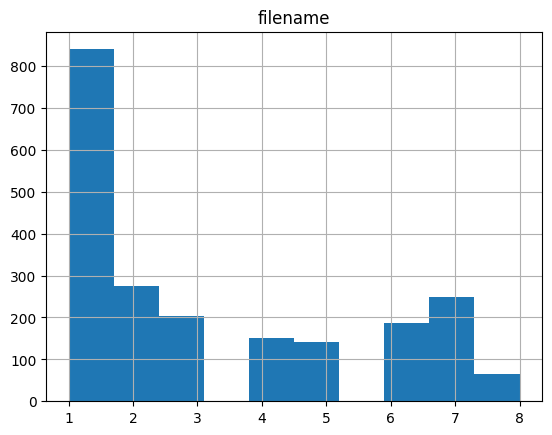

In [ ]:
import matplotlib.pyplot as plt
#span_agg = df.groupby(["start", "end", "label", "input_hash", "text"]).count()
span_agg = df.groupby(["start", "end", "label", "input_hash"]).count()
span_agg.hist("filename")

In [ ]:
# get a list of the annotators in each histogram bucket

# join
df_with_span_agg = df.merge(span_agg, on=["start", "end", "label", "input_hash"], suffixes=("", "_agg"))

# find annotators of spans with only one (no agreement)
df_with_span_agg[df_with_span_agg["count_agg"] == 1].groupby("annotator").count()

,start,end,label,input_hash,filename,linenum,text,count,filename_agg,linenum_agg,annotator_agg,text_agg,count_agg
annotator,,,,,,,,,,,,,
pilot1_review-Henry%20%20(replace%20%3Cyour%20name%3E%20with%20your%20first%20name,111,111,111,111,111,111,111,111,111,111,111,111,111
pilot1_review-Jenny,66,66,66,66,66,66,66,66,66,66,66,66,66
pilot1_review-abe,45,45,45,45,45,45,45,45,45,45,45,45,45
pilot1_review-manojkumar,118,118,118,118,118,118,118,118,118,118,118,118,118
pilot1_review-meenu,50,50,50,50,50,50,50,50,50,50,50,50,50
pilot1_review-mengyuan,159,159,159,159,159,159,159,159,159,159,159,159,159
pilot1_review-rohith,291,291,291,291,291,291,291,291,291,291,291,291,291


In [ ]:
# find annotators of spans that have 6 or 7 agreements
df_with_span_agg[df_with_span_agg["count_agg"] >=6 ].groupby("annotator").count()

,start,end,label,input_hash,filename,linenum,text,count,filename_agg,linenum_agg,annotator_agg,text_agg,count_agg
annotator,,,,,,,,,,,,,
pilot1_review-Henry%20%20(replace%20%3Cyour%20name%3E%20with%20your%20first%20name,489,489,489,489,489,489,489,489,489,489,489,489,489
pilot1_review-Jenny,498,498,498,498,498,498,498,498,498,498,498,498,498
pilot1_review-abe,489,489,489,489,489,489,489,489,489,489,489,489,489
pilot1_review-manojkumar,588,588,588,588,588,588,588,588,588,588,588,588,588
pilot1_review-meenu,493,493,493,493,493,493,493,493,493,493,493,493,493
pilot1_review-mengyuan,486,486,486,486,486,486,486,486,486,486,486,486,486
pilot1_review-rohith,336,336,336,336,336,336,336,336,336,336,336,336,336


## find all spans with 3 or more agreements


In [ ]:
spans_with_counts = df.groupby(["start", "end", "label", "filename", "linenum", "text"]).count().sort_values(["filename", "linenum"]).drop(columns=["input_hash", "annotator"])

In [ ]:
spans_with_counts[spans_with_counts["count"] >= 3]

,,,,,,count
start,end,label,filename,linenum,text,
0,42,POSITIVE,201840SEIS632-01.txt,0,"A decent course, with interesting material",6
48,157,NEGATIVE,201840SEIS632-01.txt,0,having a professor (Kazemzadeh) teach from another professor's (Rege) materials and slides seemed ineffective,6
68,78,REDACT,201840SEIS632-01.txt,0,Kazemzadeh,7
112,116,REDACT,201840SEIS632-01.txt,0,Rege,7
159,279,NEGATIVE,201840SEIS632-01.txt,0,"The lack of a course text, or something more concrete to follow lead to confusion at times in knowing what was pertinent",6
...,...,...,...,...,...,...
90,174,POSITIVE,202320SEIS630-03.txt,6,He provided ways to make the learning interactive and related it to real life events,6
176,305,POSITIVE,202320SEIS630-03.txt,6,Overall this class was very enjoyable and I learned alot more about oracle and other databases which will help in my current job!,4
0,58,POSITIVE,202320SEIS630-03.txt,7,Very knowledgeable and passionate about the subject taught,5


In [ ]:
from collections import Counter
import numpy as np

def compute_span_confusion(annotator_spans_list):
    """
    Compute a confusion matrix between annotators.
    Treat missing spans as NEUTRAL (special label).
    """
    confusion = Counter()
    NEUTRAL = 'NEUTRAL'

    n = len(annotator_spans_list)
    for i in range(n):
        for j in range(i + 1, n):
            spans_i = set(annotator_spans_list[i])
            spans_j = set(annotator_spans_list[j])

            all_spans = spans_i.union(spans_j)

            for span in all_spans:
                label_i = span if span in spans_i else NEUTRAL
                label_j = span if span in spans_j else NEUTRAL
                confusion[(label_i, label_j)] += 1

    return confusion

### Jenny's Add on

What I did:

Fix the annotator confusion to handle neutral/missing spans

export a "gold" dataset (spans with ≥ 3 annotator agreements).


### handle neutral/missing spans

In [ ]:
from itertools import product

annotator_confusion_fixed = Counter()

for input_hash, reviews in reviews_by_input.items():
    if len(reviews) < 2:
        continue

    annotators = [r["reviewer"] for r in reviews]
    spans_by_annotator = {r["reviewer"]: r["spans"] for r in reviews}

    # Create set of all span regions from all annotators
    all_spans = set()
    for spans in spans_by_annotator.values():
        for s in spans:
            all_spans.add((s[0], s[1]))  # (start, end)

    for (annotator_i, annotator_j) in product(annotators, repeat=2):
        spans_i = {(s[0], s[1]): s[2] for s in spans_by_annotator.get(annotator_i, [])}
        spans_j = {(s[0], s[1]): s[2] for s in spans_by_annotator.get(annotator_j, [])}

        for (start, end) in all_spans:
            label_i = spans_i.get((start, end), "NO_LABEL")
            label_j = spans_j.get((start, end), "NO_LABEL")
            key = (label_i, label_j)
            annotator_confusion_fixed[(annotator_i, annotator_j, key)] += 1


In [ ]:
annotators = sorted({a for (a, _, _) in annotator_confusion_fixed.keys()})
labels = sorted({l for (_, _, (l, _)) in annotator_confusion_fixed.keys()} | {l for (_, _, (_, l)) in annotator_confusion_fixed.keys()})

In [ ]:
for reviewer_i in annotators:
    for reviewer_j in annotators:
        matrix = pd.DataFrame(index=labels, columns=labels).fillna(0)
        for (ai, aj, (li, lj)), count in annotator_confusion_fixed.items():
            if ai == reviewer_i and aj == reviewer_j:
                matrix.at[li, lj] += count
        print(f"\n📊 Annotator Confusion Matrix ({reviewer_i} vs {reviewer_j}):")
        display(matrix.style.background_gradient(cmap="Blues"))


📊 Annotator Confusion Matrix (pilot1_review-Henry%20%20(replace%20%3Cyour%20name%3E%20with%20your%20first%20name vs pilot1_review-Henry%20%20(replace%20%3Cyour%20name%3E%20with%20your%20first%20name):


<ipython-input-21-98a927355e6c>:3: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  matrix = pd.DataFrame(index=labels, columns=labels).fillna(0)


,COMPARISON,NEGATIVE,NO_LABEL,POSITIVE,REDACT,SUGGESTION,UNSURE
COMPARISON,7,0,0,0,0,0,0
NEGATIVE,0,206,0,0,0,0,0
NO_LABEL,0,0,993,0,0,0,0
POSITIVE,0,0,0,339,0,0,0
REDACT,0,0,0,0,290,0,0
SUGGESTION,0,0,0,0,0,146,0
UNSURE,0,0,0,0,0,0,25



📊 Annotator Confusion Matrix (pilot1_review-Henry%20%20(replace%20%3Cyour%20name%3E%20with%20your%20first%20name vs pilot1_review-Jenny):


<ipython-input-21-98a927355e6c>:3: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  matrix = pd.DataFrame(index=labels, columns=labels).fillna(0)


,COMPARISON,NEGATIVE,NO_LABEL,POSITIVE,REDACT,SUGGESTION,UNSURE
COMPARISON,7,0,0,0,0,0,0
NEGATIVE,0,130,26,0,0,0,0
NO_LABEL,0,20,722,79,72,20,0
POSITIVE,0,2,155,178,0,1,0
REDACT,0,0,72,1,181,0,0
SUGGESTION,0,1,26,0,0,116,0
UNSURE,0,0,15,0,0,0,5



📊 Annotator Confusion Matrix (pilot1_review-Henry%20%20(replace%20%3Cyour%20name%3E%20with%20your%20first%20name vs pilot1_review-abe):


<ipython-input-21-98a927355e6c>:3: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  matrix = pd.DataFrame(index=labels, columns=labels).fillna(0)


,COMPARISON,NEGATIVE,NO_LABEL,POSITIVE,REDACT,SUGGESTION,UNSURE
COMPARISON,7,0,0,0,0,0,0
NEGATIVE,0,162,41,1,0,1,1
NO_LABEL,6,38,709,111,92,34,3
POSITIVE,0,3,112,221,1,1,1
REDACT,0,2,57,2,224,0,5
SUGGESTION,1,0,32,0,0,113,0
UNSURE,0,1,19,0,0,0,5



📊 Annotator Confusion Matrix (pilot1_review-Henry%20%20(replace%20%3Cyour%20name%3E%20with%20your%20first%20name vs pilot1_review-manojkumar):


<ipython-input-21-98a927355e6c>:3: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  matrix = pd.DataFrame(index=labels, columns=labels).fillna(0)


,COMPARISON,NEGATIVE,NO_LABEL,POSITIVE,REDACT,SUGGESTION,UNSURE
COMPARISON,4,0,1,0,0,0,0
NEGATIVE,0,128,33,0,0,0,2
NO_LABEL,0,26,861,95,61,30,15
POSITIVE,0,2,193,207,3,1,0
REDACT,0,2,127,1,159,0,0
SUGGESTION,0,0,37,0,0,132,0
UNSURE,0,0,20,0,0,0,5



📊 Annotator Confusion Matrix (pilot1_review-Henry%20%20(replace%20%3Cyour%20name%3E%20with%20your%20first%20name vs pilot1_review-meenu):


<ipython-input-21-98a927355e6c>:3: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  matrix = pd.DataFrame(index=labels, columns=labels).fillna(0)


,COMPARISON,NEGATIVE,NO_LABEL,POSITIVE,REDACT,SUGGESTION,UNSURE
COMPARISON,6,0,0,1,0,0,0
NEGATIVE,0,157,46,0,0,1,2
NO_LABEL,0,42,736,110,76,26,3
POSITIVE,0,4,111,222,0,1,1
REDACT,0,1,116,0,173,0,0
SUGGESTION,0,1,33,0,0,112,0
UNSURE,0,1,19,0,0,0,5



📊 Annotator Confusion Matrix (pilot1_review-Henry%20%20(replace%20%3Cyour%20name%3E%20with%20your%20first%20name vs pilot1_review-mengyuan):


<ipython-input-21-98a927355e6c>:3: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  matrix = pd.DataFrame(index=labels, columns=labels).fillna(0)


,COMPARISON,NEGATIVE,NO_LABEL,POSITIVE,REDACT,SUGGESTION,UNSURE
COMPARISON,7,0,0,0,0,0,0
NEGATIVE,0,154,51,0,0,0,1
NO_LABEL,0,60,750,90,44,30,19
POSITIVE,0,1,102,235,0,1,0
REDACT,0,2,140,1,147,0,0
SUGGESTION,0,1,19,0,0,126,0
UNSURE,0,0,17,0,0,1,7



📊 Annotator Confusion Matrix (pilot1_review-Henry%20%20(replace%20%3Cyour%20name%3E%20with%20your%20first%20name vs pilot1_review-rohith):


<ipython-input-21-98a927355e6c>:3: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  matrix = pd.DataFrame(index=labels, columns=labels).fillna(0)


,COMPARISON,NEGATIVE,NO_LABEL,POSITIVE,REDACT,SUGGESTION,UNSURE
COMPARISON,1,2,2,2,0,0,0
NEGATIVE,1,108,92,2,1,0,2
NO_LABEL,3,101,521,196,90,72,10
POSITIVE,0,1,192,143,1,0,2
REDACT,0,2,96,1,186,0,5
SUGGESTION,0,8,72,1,0,65,0
UNSURE,0,1,21,2,0,0,1



📊 Annotator Confusion Matrix (pilot1_review-Jenny vs pilot1_review-Henry%20%20(replace%20%3Cyour%20name%3E%20with%20your%20first%20name):


<ipython-input-21-98a927355e6c>:3: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  matrix = pd.DataFrame(index=labels, columns=labels).fillna(0)


,COMPARISON,NEGATIVE,NO_LABEL,POSITIVE,REDACT,SUGGESTION,UNSURE
COMPARISON,7,0,0,0,0,0,0
NEGATIVE,0,130,20,2,0,1,0
NO_LABEL,0,26,722,155,72,26,15
POSITIVE,0,0,79,178,1,0,0
REDACT,0,0,72,0,181,0,0
SUGGESTION,0,0,20,1,0,116,0
UNSURE,0,0,0,0,0,0,5



📊 Annotator Confusion Matrix (pilot1_review-Jenny vs pilot1_review-Jenny):


<ipython-input-21-98a927355e6c>:3: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  matrix = pd.DataFrame(index=labels, columns=labels).fillna(0)


,COMPARISON,NEGATIVE,NO_LABEL,POSITIVE,REDACT,SUGGESTION,UNSURE
COMPARISON,7,0,0,0,0,0,0
NEGATIVE,0,153,0,0,0,0,0
NO_LABEL,0,0,1016,0,0,0,0
POSITIVE,0,0,0,258,0,0,0
REDACT,0,0,0,0,253,0,0
SUGGESTION,0,0,0,0,0,137,0
UNSURE,0,0,0,0,0,0,5



📊 Annotator Confusion Matrix (pilot1_review-Jenny vs pilot1_review-abe):


<ipython-input-21-98a927355e6c>:3: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  matrix = pd.DataFrame(index=labels, columns=labels).fillna(0)


,COMPARISON,NEGATIVE,NO_LABEL,POSITIVE,REDACT,SUGGESTION,UNSURE
COMPARISON,7,0,0,0,0,0,0
NEGATIVE,0,132,19,0,0,2,0
NO_LABEL,6,27,741,142,78,21,1
POSITIVE,0,0,71,186,0,0,1
REDACT,0,0,49,0,204,0,0
SUGGESTION,1,0,14,0,1,121,0
UNSURE,0,0,1,0,0,0,4



📊 Annotator Confusion Matrix (pilot1_review-Jenny vs pilot1_review-manojkumar):


<ipython-input-21-98a927355e6c>:3: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  matrix = pd.DataFrame(index=labels, columns=labels).fillna(0)


,COMPARISON,NEGATIVE,NO_LABEL,POSITIVE,REDACT,SUGGESTION,UNSURE
COMPARISON,4,0,1,0,0,0,0
NEGATIVE,0,138,19,0,1,0,1
NO_LABEL,0,20,1057,54,54,16,17
POSITIVE,0,0,50,249,4,0,0
REDACT,0,0,131,0,164,0,0
SUGGESTION,0,0,14,0,0,147,0
UNSURE,0,0,0,0,0,0,4



📊 Annotator Confusion Matrix (pilot1_review-Jenny vs pilot1_review-meenu):


<ipython-input-21-98a927355e6c>:3: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  matrix = pd.DataFrame(index=labels, columns=labels).fillna(0)


,COMPARISON,NEGATIVE,NO_LABEL,POSITIVE,REDACT,SUGGESTION,UNSURE
COMPARISON,6,0,0,1,0,0,0
NEGATIVE,0,133,18,0,0,2,0
NO_LABEL,0,26,776,138,57,19,0
POSITIVE,0,0,68,189,0,0,1
REDACT,0,0,101,0,152,0,0
SUGGESTION,0,1,22,0,0,114,0
UNSURE,0,0,1,0,0,0,4


<ipython-input-21-98a927355e6c>:3: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  matrix = pd.DataFrame(index=labels, columns=labels).fillna(0)



📊 Annotator Confusion Matrix (pilot1_review-Jenny vs pilot1_review-mengyuan):


,COMPARISON,NEGATIVE,NO_LABEL,POSITIVE,REDACT,SUGGESTION,UNSURE
COMPARISON,7,0,0,0,0,0,0
NEGATIVE,0,127,24,0,0,1,1
NO_LABEL,0,35,751,148,29,35,18
POSITIVE,0,0,83,175,0,0,0
REDACT,0,0,116,0,137,0,0
SUGGESTION,0,0,18,0,0,119,0
UNSURE,0,0,0,0,0,0,5


<ipython-input-21-98a927355e6c>:3: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  matrix = pd.DataFrame(index=labels, columns=labels).fillna(0)



📊 Annotator Confusion Matrix (pilot1_review-Jenny vs pilot1_review-rohith):


,COMPARISON,NEGATIVE,NO_LABEL,POSITIVE,REDACT,SUGGESTION,UNSURE
COMPARISON,1,2,2,2,0,0,0
NEGATIVE,0,79,69,2,1,0,2
NO_LABEL,4,86,552,207,94,65,8
POSITIVE,0,0,130,127,0,0,1
REDACT,0,0,101,0,152,0,0
SUGGESTION,0,6,60,1,1,69,0
UNSURE,0,0,3,2,0,0,0


<ipython-input-21-98a927355e6c>:3: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  matrix = pd.DataFrame(index=labels, columns=labels).fillna(0)



📊 Annotator Confusion Matrix (pilot1_review-abe vs pilot1_review-Henry%20%20(replace%20%3Cyour%20name%3E%20with%20your%20first%20name):


,COMPARISON,NEGATIVE,NO_LABEL,POSITIVE,REDACT,SUGGESTION,UNSURE
COMPARISON,7,0,6,0,0,1,0
NEGATIVE,0,162,38,3,2,0,1
NO_LABEL,0,41,709,112,57,32,19
POSITIVE,0,1,111,221,2,0,0
REDACT,0,0,92,1,224,0,0
SUGGESTION,0,1,34,1,0,113,0
UNSURE,0,1,3,1,5,0,5


<ipython-input-21-98a927355e6c>:3: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  matrix = pd.DataFrame(index=labels, columns=labels).fillna(0)



📊 Annotator Confusion Matrix (pilot1_review-abe vs pilot1_review-Jenny):


,COMPARISON,NEGATIVE,NO_LABEL,POSITIVE,REDACT,SUGGESTION,UNSURE
COMPARISON,7,0,6,0,0,1,0
NEGATIVE,0,132,27,0,0,0,0
NO_LABEL,0,19,741,71,49,14,1
POSITIVE,0,0,142,186,0,0,0
REDACT,0,0,78,0,204,1,0
SUGGESTION,0,2,21,0,0,121,0
UNSURE,0,0,1,1,0,0,4


<ipython-input-21-98a927355e6c>:3: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  matrix = pd.DataFrame(index=labels, columns=labels).fillna(0)



📊 Annotator Confusion Matrix (pilot1_review-abe vs pilot1_review-abe):


,COMPARISON,NEGATIVE,NO_LABEL,POSITIVE,REDACT,SUGGESTION,UNSURE
COMPARISON,14,0,0,0,0,0,0
NEGATIVE,0,206,0,0,0,0,0
NO_LABEL,0,0,970,0,0,0,0
POSITIVE,0,0,0,335,0,0,0
REDACT,0,0,0,0,317,0,0
SUGGESTION,0,0,0,0,0,149,0
UNSURE,0,0,0,0,0,0,15


<ipython-input-21-98a927355e6c>:3: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  matrix = pd.DataFrame(index=labels, columns=labels).fillna(0)



📊 Annotator Confusion Matrix (pilot1_review-abe vs pilot1_review-manojkumar):


,COMPARISON,NEGATIVE,NO_LABEL,POSITIVE,REDACT,SUGGESTION,UNSURE
COMPARISON,4,0,9,0,0,2,0
NEGATIVE,0,126,36,0,1,0,1
NO_LABEL,0,30,861,97,46,24,18
POSITIVE,0,0,178,206,5,0,0
REDACT,0,2,155,0,171,0,0
SUGGESTION,0,0,30,0,0,137,0
UNSURE,0,0,3,0,0,0,3


<ipython-input-21-98a927355e6c>:3: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  matrix = pd.DataFrame(index=labels, columns=labels).fillna(0)



📊 Annotator Confusion Matrix (pilot1_review-abe vs pilot1_review-meenu):


,COMPARISON,NEGATIVE,NO_LABEL,POSITIVE,REDACT,SUGGESTION,UNSURE
COMPARISON,6,0,6,1,0,1,0
NEGATIVE,0,189,17,0,0,0,0
NO_LABEL,0,15,842,42,56,12,3
POSITIVE,0,1,40,289,3,0,2
REDACT,0,0,131,0,186,0,0
SUGGESTION,0,1,20,1,0,127,0
UNSURE,0,0,5,0,4,0,6


<ipython-input-21-98a927355e6c>:3: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  matrix = pd.DataFrame(index=labels, columns=labels).fillna(0)



📊 Annotator Confusion Matrix (pilot1_review-abe vs pilot1_review-mengyuan):


,COMPARISON,NEGATIVE,NO_LABEL,POSITIVE,REDACT,SUGGESTION,UNSURE
COMPARISON,7,0,6,0,0,1,0
NEGATIVE,0,134,72,0,0,0,0
NO_LABEL,0,82,645,144,37,42,20
POSITIVE,0,1,151,182,0,1,0
REDACT,0,1,165,0,151,0,0
SUGGESTION,0,0,35,0,0,114,0
UNSURE,0,0,5,0,3,0,7



📊 Annotator Confusion Matrix (pilot1_review-abe vs pilot1_review-rohith):


<ipython-input-21-98a927355e6c>:3: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  matrix = pd.DataFrame(index=labels, columns=labels).fillna(0)


,COMPARISON,NEGATIVE,NO_LABEL,POSITIVE,REDACT,SUGGESTION,UNSURE
COMPARISON,2,2,6,3,0,1,0
NEGATIVE,1,133,67,1,1,0,3
NO_LABEL,2,78,634,137,55,57,7
POSITIVE,0,0,131,203,0,0,1
REDACT,0,0,95,0,222,0,0
SUGGESTION,0,10,59,1,0,79,0
UNSURE,0,0,4,2,0,0,9


<ipython-input-21-98a927355e6c>:3: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  matrix = pd.DataFrame(index=labels, columns=labels).fillna(0)



📊 Annotator Confusion Matrix (pilot1_review-manojkumar vs pilot1_review-Henry%20%20(replace%20%3Cyour%20name%3E%20with%20your%20first%20name):


,COMPARISON,NEGATIVE,NO_LABEL,POSITIVE,REDACT,SUGGESTION,UNSURE
COMPARISON,4,0,0,0,0,0,0
NEGATIVE,0,128,26,2,2,0,0
NO_LABEL,1,33,861,193,127,37,20
POSITIVE,0,0,95,207,1,0,0
REDACT,0,0,61,3,159,0,0
SUGGESTION,0,0,30,1,0,132,0
UNSURE,0,2,15,0,0,0,5



📊 Annotator Confusion Matrix (pilot1_review-manojkumar vs pilot1_review-Jenny):


<ipython-input-21-98a927355e6c>:3: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  matrix = pd.DataFrame(index=labels, columns=labels).fillna(0)


,COMPARISON,NEGATIVE,NO_LABEL,POSITIVE,REDACT,SUGGESTION,UNSURE
COMPARISON,4,0,0,0,0,0,0
NEGATIVE,0,138,20,0,0,0,0
NO_LABEL,1,19,1057,50,131,14,0
POSITIVE,0,0,54,249,0,0,0
REDACT,0,1,54,4,164,0,0
SUGGESTION,0,0,16,0,0,147,0
UNSURE,0,1,17,0,0,0,4



📊 Annotator Confusion Matrix (pilot1_review-manojkumar vs pilot1_review-abe):


<ipython-input-21-98a927355e6c>:3: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  matrix = pd.DataFrame(index=labels, columns=labels).fillna(0)


,COMPARISON,NEGATIVE,NO_LABEL,POSITIVE,REDACT,SUGGESTION,UNSURE
COMPARISON,4,0,0,0,0,0,0
NEGATIVE,0,126,30,0,2,0,0
NO_LABEL,9,36,861,178,155,30,3
POSITIVE,0,0,97,206,0,0,0
REDACT,0,1,46,5,171,0,0
SUGGESTION,2,0,24,0,0,137,0
UNSURE,0,1,18,0,0,0,3



📊 Annotator Confusion Matrix (pilot1_review-manojkumar vs pilot1_review-manojkumar):


<ipython-input-21-98a927355e6c>:3: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  matrix = pd.DataFrame(index=labels, columns=labels).fillna(0)


,COMPARISON,NEGATIVE,NO_LABEL,POSITIVE,REDACT,SUGGESTION,UNSURE
COMPARISON,8,0,0,0,0,0,0
NEGATIVE,0,226,0,0,0,0,0
NO_LABEL,0,0,2030,0,0,0,0
POSITIVE,0,0,0,447,0,0,0
REDACT,0,0,0,0,287,0,0
SUGGESTION,0,0,0,0,0,243,0
UNSURE,0,0,0,0,0,0,22


<ipython-input-21-98a927355e6c>:3: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  matrix = pd.DataFrame(index=labels, columns=labels).fillna(0)



📊 Annotator Confusion Matrix (pilot1_review-manojkumar vs pilot1_review-meenu):


,COMPARISON,NEGATIVE,NO_LABEL,POSITIVE,REDACT,SUGGESTION,UNSURE
COMPARISON,2,0,0,2,0,0,0
NEGATIVE,0,133,21,0,4,0,0
NO_LABEL,1,27,951,174,91,27,1
POSITIVE,0,1,89,213,0,0,0
REDACT,0,1,61,4,157,0,0
SUGGESTION,0,2,32,1,0,128,0
UNSURE,0,1,18,0,0,0,3



📊 Annotator Confusion Matrix (pilot1_review-manojkumar vs pilot1_review-mengyuan):


<ipython-input-21-98a927355e6c>:3: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  matrix = pd.DataFrame(index=labels, columns=labels).fillna(0)


,COMPARISON,NEGATIVE,NO_LABEL,POSITIVE,REDACT,SUGGESTION,UNSURE
COMPARISON,4,0,0,0,0,0,0
NEGATIVE,0,132,25,0,0,0,1
NO_LABEL,1,40,948,170,47,46,20
POSITIVE,0,0,89,214,0,0,0
REDACT,0,0,77,1,145,0,0
SUGGESTION,0,0,27,0,0,136,0
UNSURE,0,3,11,0,0,1,7


<ipython-input-21-98a927355e6c>:3: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  matrix = pd.DataFrame(index=labels, columns=labels).fillna(0)



📊 Annotator Confusion Matrix (pilot1_review-manojkumar vs pilot1_review-rohith):


,COMPARISON,NEGATIVE,NO_LABEL,POSITIVE,REDACT,SUGGESTION,UNSURE
COMPARISON,2,2,0,0,0,0,0
NEGATIVE,0,63,90,2,3,0,0
NO_LABEL,4,100,659,255,158,81,15
POSITIVE,0,0,167,134,0,0,2
REDACT,0,1,84,5,133,0,0
SUGGESTION,0,3,86,1,0,73,0
UNSURE,1,1,18,2,0,0,0



📊 Annotator Confusion Matrix (pilot1_review-meenu vs pilot1_review-Henry%20%20(replace%20%3Cyour%20name%3E%20with%20your%20first%20name):


<ipython-input-21-98a927355e6c>:3: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  matrix = pd.DataFrame(index=labels, columns=labels).fillna(0)


,COMPARISON,NEGATIVE,NO_LABEL,POSITIVE,REDACT,SUGGESTION,UNSURE
COMPARISON,6,0,0,0,0,0,0
NEGATIVE,0,157,42,4,1,1,1
NO_LABEL,0,46,736,111,116,33,19
POSITIVE,1,0,110,222,0,0,0
REDACT,0,0,76,0,173,0,0
SUGGESTION,0,1,26,1,0,112,0
UNSURE,0,2,3,1,0,0,5


<ipython-input-21-98a927355e6c>:3: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  matrix = pd.DataFrame(index=labels, columns=labels).fillna(0)



📊 Annotator Confusion Matrix (pilot1_review-meenu vs pilot1_review-Jenny):


,COMPARISON,NEGATIVE,NO_LABEL,POSITIVE,REDACT,SUGGESTION,UNSURE
COMPARISON,6,0,0,0,0,0,0
NEGATIVE,0,133,26,0,0,1,0
NO_LABEL,0,18,776,68,101,22,1
POSITIVE,1,0,138,189,0,0,0
REDACT,0,0,57,0,152,0,0
SUGGESTION,0,2,19,0,0,114,0
UNSURE,0,0,0,1,0,0,4



📊 Annotator Confusion Matrix (pilot1_review-meenu vs pilot1_review-abe):


<ipython-input-21-98a927355e6c>:3: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  matrix = pd.DataFrame(index=labels, columns=labels).fillna(0)


,COMPARISON,NEGATIVE,NO_LABEL,POSITIVE,REDACT,SUGGESTION,UNSURE
COMPARISON,6,0,0,0,0,0,0
NEGATIVE,0,189,15,1,0,1,0
NO_LABEL,6,17,842,40,131,20,5
POSITIVE,1,0,42,289,0,1,0
REDACT,0,0,56,3,186,0,4
SUGGESTION,1,0,12,0,0,127,0
UNSURE,0,0,3,2,0,0,6



📊 Annotator Confusion Matrix (pilot1_review-meenu vs pilot1_review-manojkumar):


<ipython-input-21-98a927355e6c>:3: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  matrix = pd.DataFrame(index=labels, columns=labels).fillna(0)


,COMPARISON,NEGATIVE,NO_LABEL,POSITIVE,REDACT,SUGGESTION,UNSURE
COMPARISON,2,0,1,0,0,0,0
NEGATIVE,0,133,27,1,1,2,1
NO_LABEL,0,21,951,89,61,32,18
POSITIVE,2,0,174,213,4,1,0
REDACT,0,4,91,0,157,0,0
SUGGESTION,0,0,27,0,0,128,0
UNSURE,0,0,1,0,0,0,3


<ipython-input-21-98a927355e6c>:3: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  matrix = pd.DataFrame(index=labels, columns=labels).fillna(0)



📊 Annotator Confusion Matrix (pilot1_review-meenu vs pilot1_review-meenu):


,COMPARISON,NEGATIVE,NO_LABEL,POSITIVE,REDACT,SUGGESTION,UNSURE
COMPARISON,6,0,0,0,0,0,0
NEGATIVE,0,206,0,0,0,0,0
NO_LABEL,0,0,1061,0,0,0,0
POSITIVE,0,0,0,333,0,0,0
REDACT,0,0,0,0,249,0,0
SUGGESTION,0,0,0,0,0,140,0
UNSURE,0,0,0,0,0,0,11


<ipython-input-21-98a927355e6c>:3: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  matrix = pd.DataFrame(index=labels, columns=labels).fillna(0)



📊 Annotator Confusion Matrix (pilot1_review-meenu vs pilot1_review-mengyuan):


,COMPARISON,NEGATIVE,NO_LABEL,POSITIVE,REDACT,SUGGESTION,UNSURE
COMPARISON,6,0,0,0,0,0,0
NEGATIVE,0,135,70,0,0,1,0
NO_LABEL,0,80,762,135,16,47,21
POSITIVE,1,0,141,191,0,0,0
REDACT,0,2,72,0,175,0,0
SUGGESTION,0,0,30,0,0,110,0
UNSURE,0,1,4,0,0,0,6



📊 Annotator Confusion Matrix (pilot1_review-meenu vs pilot1_review-rohith):


<ipython-input-21-98a927355e6c>:3: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  matrix = pd.DataFrame(index=labels, columns=labels).fillna(0)


,COMPARISON,NEGATIVE,NO_LABEL,POSITIVE,REDACT,SUGGESTION,UNSURE
COMPARISON,0,2,2,2,0,0,0
NEGATIVE,1,122,78,2,1,0,2
NO_LABEL,3,90,632,139,119,67,11
POSITIVE,1,0,136,195,0,0,1
REDACT,0,0,84,3,158,0,4
SUGGESTION,0,9,60,1,0,70,0
UNSURE,0,0,4,5,0,0,2


<ipython-input-21-98a927355e6c>:3: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  matrix = pd.DataFrame(index=labels, columns=labels).fillna(0)



📊 Annotator Confusion Matrix (pilot1_review-mengyuan vs pilot1_review-Henry%20%20(replace%20%3Cyour%20name%3E%20with%20your%20first%20name):


,COMPARISON,NEGATIVE,NO_LABEL,POSITIVE,REDACT,SUGGESTION,UNSURE
COMPARISON,7,0,0,0,0,0,0
NEGATIVE,0,154,60,1,2,1,0
NO_LABEL,0,51,750,102,140,19,17
POSITIVE,0,0,90,235,1,0,0
REDACT,0,0,44,0,147,0,0
SUGGESTION,0,0,30,1,0,126,1
UNSURE,0,1,19,0,0,0,7



📊 Annotator Confusion Matrix (pilot1_review-mengyuan vs pilot1_review-Jenny):


<ipython-input-21-98a927355e6c>:3: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  matrix = pd.DataFrame(index=labels, columns=labels).fillna(0)


,COMPARISON,NEGATIVE,NO_LABEL,POSITIVE,REDACT,SUGGESTION,UNSURE
COMPARISON,7,0,0,0,0,0,0
NEGATIVE,0,127,35,0,0,0,0
NO_LABEL,0,24,751,83,116,18,0
POSITIVE,0,0,148,175,0,0,0
REDACT,0,0,29,0,137,0,0
SUGGESTION,0,1,35,0,0,119,0
UNSURE,0,1,18,0,0,0,5


<ipython-input-21-98a927355e6c>:3: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  matrix = pd.DataFrame(index=labels, columns=labels).fillna(0)



📊 Annotator Confusion Matrix (pilot1_review-mengyuan vs pilot1_review-abe):


,COMPARISON,NEGATIVE,NO_LABEL,POSITIVE,REDACT,SUGGESTION,UNSURE
COMPARISON,7,0,0,0,0,0,0
NEGATIVE,0,134,82,1,1,0,0
NO_LABEL,6,72,645,151,165,35,5
POSITIVE,0,0,144,182,0,0,0
REDACT,0,0,37,0,151,0,3
SUGGESTION,1,0,42,1,0,114,0
UNSURE,0,0,20,0,0,0,7


<ipython-input-21-98a927355e6c>:3: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  matrix = pd.DataFrame(index=labels, columns=labels).fillna(0)



📊 Annotator Confusion Matrix (pilot1_review-mengyuan vs pilot1_review-manojkumar):


,COMPARISON,NEGATIVE,NO_LABEL,POSITIVE,REDACT,SUGGESTION,UNSURE
COMPARISON,4,0,1,0,0,0,0
NEGATIVE,0,132,40,0,0,0,3
NO_LABEL,0,25,948,89,77,27,11
POSITIVE,0,0,170,214,1,0,0
REDACT,0,0,47,0,145,0,0
SUGGESTION,0,0,46,0,0,136,1
UNSURE,0,1,20,0,0,0,7


<ipython-input-21-98a927355e6c>:3: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  matrix = pd.DataFrame(index=labels, columns=labels).fillna(0)



📊 Annotator Confusion Matrix (pilot1_review-mengyuan vs pilot1_review-meenu):


,COMPARISON,NEGATIVE,NO_LABEL,POSITIVE,REDACT,SUGGESTION,UNSURE
COMPARISON,6,0,0,1,0,0,0
NEGATIVE,0,135,80,0,2,0,1
NO_LABEL,0,70,762,141,72,30,4
POSITIVE,0,0,135,191,0,0,0
REDACT,0,0,16,0,175,0,0
SUGGESTION,0,1,47,0,0,110,0
UNSURE,0,0,21,0,0,0,6


<ipython-input-21-98a927355e6c>:3: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  matrix = pd.DataFrame(index=labels, columns=labels).fillna(0)



📊 Annotator Confusion Matrix (pilot1_review-mengyuan vs pilot1_review-mengyuan):


,COMPARISON,NEGATIVE,NO_LABEL,POSITIVE,REDACT,SUGGESTION,UNSURE
COMPARISON,7,0,0,0,0,0,0
NEGATIVE,0,218,0,0,0,0,0
NO_LABEL,0,0,1079,0,0,0,0
POSITIVE,0,0,0,326,0,0,0
REDACT,0,0,0,0,191,0,0
SUGGESTION,0,0,0,0,0,158,0
UNSURE,0,0,0,0,0,0,27


<ipython-input-21-98a927355e6c>:3: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  matrix = pd.DataFrame(index=labels, columns=labels).fillna(0)



📊 Annotator Confusion Matrix (pilot1_review-mengyuan vs pilot1_review-rohith):


,COMPARISON,NEGATIVE,NO_LABEL,POSITIVE,REDACT,SUGGESTION,UNSURE
COMPARISON,1,2,2,2,0,0,0
NEGATIVE,0,85,129,2,2,0,0
NO_LABEL,4,128,488,228,147,71,13
POSITIVE,0,0,213,112,0,0,1
REDACT,0,0,59,0,129,0,3
SUGGESTION,0,8,83,1,0,66,0
UNSURE,0,0,22,2,0,0,3


<ipython-input-21-98a927355e6c>:3: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  matrix = pd.DataFrame(index=labels, columns=labels).fillna(0)



📊 Annotator Confusion Matrix (pilot1_review-rohith vs pilot1_review-Henry%20%20(replace%20%3Cyour%20name%3E%20with%20your%20first%20name):


,COMPARISON,NEGATIVE,NO_LABEL,POSITIVE,REDACT,SUGGESTION,UNSURE
COMPARISON,1,1,3,0,0,0,0
NEGATIVE,2,108,101,1,2,8,1
NO_LABEL,2,92,521,192,96,72,21
POSITIVE,2,2,196,143,1,1,2
REDACT,0,1,90,1,186,0,0
SUGGESTION,0,0,72,0,0,65,0
UNSURE,0,2,10,2,5,0,1


<ipython-input-21-98a927355e6c>:3: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  matrix = pd.DataFrame(index=labels, columns=labels).fillna(0)



📊 Annotator Confusion Matrix (pilot1_review-rohith vs pilot1_review-Jenny):


,COMPARISON,NEGATIVE,NO_LABEL,POSITIVE,REDACT,SUGGESTION,UNSURE
COMPARISON,1,0,4,0,0,0,0
NEGATIVE,2,79,86,0,0,6,0
NO_LABEL,2,69,552,130,101,60,3
POSITIVE,2,2,207,127,0,1,2
REDACT,0,1,94,0,152,1,0
SUGGESTION,0,0,65,0,0,69,0
UNSURE,0,2,8,1,0,0,0


<ipython-input-21-98a927355e6c>:3: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  matrix = pd.DataFrame(index=labels, columns=labels).fillna(0)



📊 Annotator Confusion Matrix (pilot1_review-rohith vs pilot1_review-abe):


,COMPARISON,NEGATIVE,NO_LABEL,POSITIVE,REDACT,SUGGESTION,UNSURE
COMPARISON,2,1,2,0,0,0,0
NEGATIVE,2,133,78,0,0,10,0
NO_LABEL,6,67,634,131,95,59,4
POSITIVE,3,1,137,203,0,1,2
REDACT,0,1,55,0,222,0,0
SUGGESTION,1,0,57,0,0,79,0
UNSURE,0,3,7,1,0,0,9


<ipython-input-21-98a927355e6c>:3: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  matrix = pd.DataFrame(index=labels, columns=labels).fillna(0)



📊 Annotator Confusion Matrix (pilot1_review-rohith vs pilot1_review-manojkumar):


,COMPARISON,NEGATIVE,NO_LABEL,POSITIVE,REDACT,SUGGESTION,UNSURE
COMPARISON,2,0,4,0,0,0,1
NEGATIVE,2,63,100,0,1,3,1
NO_LABEL,0,90,659,167,84,86,18
POSITIVE,0,2,255,134,5,1,2
REDACT,0,3,158,0,133,0,0
SUGGESTION,0,0,81,0,0,73,0
UNSURE,0,0,15,2,0,0,0


<ipython-input-21-98a927355e6c>:3: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  matrix = pd.DataFrame(index=labels, columns=labels).fillna(0)



📊 Annotator Confusion Matrix (pilot1_review-rohith vs pilot1_review-meenu):


,COMPARISON,NEGATIVE,NO_LABEL,POSITIVE,REDACT,SUGGESTION,UNSURE
COMPARISON,0,1,3,1,0,0,0
NEGATIVE,2,122,90,0,0,9,0
NO_LABEL,2,78,632,136,84,60,4
POSITIVE,2,2,139,195,3,1,5
REDACT,0,1,119,0,158,0,0
SUGGESTION,0,0,67,0,0,70,0
UNSURE,0,2,11,1,4,0,2



📊 Annotator Confusion Matrix (pilot1_review-rohith vs pilot1_review-mengyuan):


<ipython-input-21-98a927355e6c>:3: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  matrix = pd.DataFrame(index=labels, columns=labels).fillna(0)


,COMPARISON,NEGATIVE,NO_LABEL,POSITIVE,REDACT,SUGGESTION,UNSURE
COMPARISON,1,0,4,0,0,0,0
NEGATIVE,2,85,128,0,0,8,0
NO_LABEL,2,129,488,213,59,83,22
POSITIVE,2,2,228,112,0,1,2
REDACT,0,2,147,0,129,0,0
SUGGESTION,0,0,71,0,0,66,0
UNSURE,0,0,13,1,3,0,3


<ipython-input-21-98a927355e6c>:3: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  matrix = pd.DataFrame(index=labels, columns=labels).fillna(0)



📊 Annotator Confusion Matrix (pilot1_review-rohith vs pilot1_review-rohith):


,COMPARISON,NEGATIVE,NO_LABEL,POSITIVE,REDACT,SUGGESTION,UNSURE
COMPARISON,5,0,0,0,0,0,0
NEGATIVE,0,223,0,0,0,0,0
NO_LABEL,0,0,996,0,0,0,0
POSITIVE,0,0,0,347,0,0,0
REDACT,0,0,0,0,278,0,0
SUGGESTION,0,0,0,0,0,137,0
UNSURE,0,0,0,0,0,0,20


### Export spans with 3+ agreements as a "gold" dataset

In [ ]:
gold_spans = spans_with_counts[spans_with_counts["count"] >= 3].reset_index()

gold_data = []

for idx, row in gold_spans.iterrows():
    gold_data.append({
        "filename": row["filename"],
        "linenum": int(row["linenum"]),
        "start": int(row["start"]),
        "end": int(row["end"]),
        "text": row["text"],
        "label": row["label"],
        "agreement_count": int(row["count"])
    })

In [ ]:
output_path = "gold_spans.jsonl"
with open(output_path, "w", encoding="utf-8") as f:
    for entry in gold_data:
        f.write(json.dumps(entry, ensure_ascii=False) + "\n")


In [ ]:
print(f"✅ Exported {len(gold_data)} gold spans to {output_path}")

✅ Exported 998 gold spans to gold_spans.jsonl
